##### Import modules and set up file locations

In [4]:
import Sequence_Analysis_Routines as sar
import random
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import logomaker as lm
import math
import pandas as pd
import subprocess
import numpy as np
import ete3

In [5]:
project_dir = 'D:/Project_Data/Project_3'
sonic_paranoid_run_name = 'Run_0'
outgroup_sonic_paranoid_run_name = 'Run_1'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets_Close_Species/'
output_dir = project_dir + '/Output/Close_Species'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
outgroup_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
single_copy_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/single-copy_groups.tsv'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'

In [6]:
tb_species = 'GCF_000195955.2'
outgroup_species = 'NC_008596.1'

##### Determine genomes in ortholog family, generate protein files and run Sonic Paranoid

In [7]:
genome_ids_with_outgroup = sar.list_dirs(genome_datasets_dir)
genome_ids = sar.list_dirs(genome_datasets_dir)
genome_ids.remove(outgroup_species)
num_ids = len(genome_ids)
#num_ids = len(genome_ids_with_outgroup)

In [5]:
for folder in sar.tqdm(genome_ids):
    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', protein_fasta_output_loc + '/' + folder + '.faa')
#for folder in sar.tqdm(genome_ids_with_outgroup):
#    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', protein_fasta_output_loc + '/' + folder + '.faa')

100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


In [6]:
#sar.run_sonic_paranoid(protein_fasta_output_loc, sonic_paranoid_output_loc, sonic_paranoid_run_name)
#sar.run_sonic_paranoid(protein_fasta_output_loc, sonic_paranoid_output_loc, outgroup_sonic_paranoid_run_name)

##### Generate ortholog object and object containing sequence information for each ortholog group / species

In [8]:
orthologs = sar.Ortholog_Grouping(ortholog_file_ref)
#orthologs = sar.Ortholog_Grouping(outgroup_ortholog_file_ref)

100%|██████████| 28704/28704 [00:01<00:00, 21147.50it/s]


In [9]:
offset = 50

In [10]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, offset, tb_species) 

100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


##### Perform CDS and non-CDS alignments for each full ortholog group and save to folders

In [10]:
min_species = num_ids
num_cores = 16
core_numbers = list(range(1, num_cores+1))
groups = random.sample(orthologs.full_ortholog_groups, len(orthologs.full_ortholog_groups))  #Permutation ensures even distribution of processing speeds
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_length', 'cds_seq', outgroup_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_length', 'cds_seq', cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'non_cds_offset_length', 'non_cds_offset_seq', non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'upstream_non_cds_offset_length', 'upstream_non_cds_offset_seq', upstream_non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))

##### Remove portions of alignment gapped for TB and plot entropies and logos

In [11]:
group_id = 170 #1569 #1505 #1167 #170 #196  #1700
alignment = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
alignment.modify_sequence(1,False,True)
alignment.calculate_entropies(mvave_len = 10)

In [12]:
utr_upstream_dict = {}
utrs = pd.read_csv(project_dir + '/Datasets/Data_From_Publications/strict_3UTRs.csv', header=0)
for i, r in tqdm(utrs.iterrows(), total=utrs.shape[0]):
    utr_upstream_dict[r['upstream']] = [r['utr'], r['start']-1, r['stop']-1, r['strand'], r['downstream']]
#putative_srna_dict = {}
#psrnas = pd.read_csv(project_dir + '/Datasets/Data_From_Publications/intergenic_putative_srnas.csv', header=0)
#for i, r in tqdm(utrs.iterrows(), total=utrs.shape[0]):
#    putative_srna_dict[r['upstream']] = [r['utr'], r['start']-1, r['stop']-1, r['strand'], r['downstream']]

100%|██████████| 586/586 [00:00<00:00, 27904.88it/s]


In [13]:
cds_end_pos = offset - 1
non_cds_end_pos = alignment.modified_sequence_length - offset
non_cds_offset_start = seq_data.master_species_info(group_id, 'non_cds_offset_start')
non_cds_offset_stop = seq_data.master_species_info(group_id, 'non_cds_offset_stop')
locus_tag = seq_data.master_species_info(group_id, 'locus_tag')
cds_strand = seq_data.master_species_info(group_id, 'strand')
if cds_strand == 1:
    downstream_locus_tag = seq_data.master_species_info(group_id, 'next_locus_tag')
    downstream_locus_strand = seq_data.master_species_info(group_id, 'next_strand')
else:
    downstream_locus_tag = seq_data.master_species_info(group_id, 'previous_locus_tag')
    downstream_locus_strand = seq_data.master_species_info(group_id, 'prev_strand')
utr_start_pos = 0
utr_end_pos = 0
if locus_tag in utr_upstream_dict:
    utr_data = utr_upstream_dict[locus_tag]
    if cds_strand == 1:
        utr_start_pos = utr_data[1] - non_cds_offset_start
        utr_end_pos = utr_data[2] - non_cds_offset_start
    else:
        utr_start_pos = non_cds_offset_stop - utr_data[2]
        utr_end_pos = non_cds_offset_stop - utr_data[1]

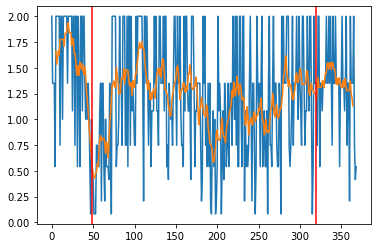

In [14]:
plt.plot(alignment.relative_entropy);
plt.plot(alignment.mvave_relative_entropy);
plt.axvline(x=cds_end_pos, ymin=0, ymax=2, color='r');
plt.axvline(x=non_cds_end_pos, ymin=0, ymax=2, color='r');

##### Run IQTree on CDS alignments to generate tree

In [ ]:
#alignment_names = sar.list_files(cds_output_dir)
#sar.concatenate_fasta(cds_output_dir, alignment_names, cds_output_dir + '/CDS/concatenated_cds.fasta')

In [ ]:
#subprocess.run('cd \\users\\nicho\\IQTree & bin\\iqtree2 -q ' + cds_output_dir + ' --prefix '+ output_dir + '/Trees/Full_Tree -m GTR+I+G -B 1000 -T AUTO', shell=True)
#subprocess.run('cd \\users\\nicho\\IQTree & bin\\iqtree2 -s ' + outgroup_cds_output_dir + '/CDS/concatenated_cds.fasta' + ' --prefix '+ output_dir + '/Trees/Concatenated_JC_Tree -m JC -B 1000 -T AUTO -o ' + outgroup_species, shell=True)

##### Estimate conserved regions based on HMM calibrated to all non-CDS (see separate calibration notebook)

In [15]:
master_tree = ete3.Tree(output_dir + '/Trees/Concatenated_JC_Tree.treefile')
outgroup = master_tree.search_nodes(name= outgroup_species)[0]
outgroup.delete()

In [25]:
#fitted_parameters = [0.98576229, 0.97154437, 8.54931842, 1.26858705]     #Viterbi
fitted_parameters = [0.97249065, 0.9457994, 8.99643063,  1.27164373 ]  #Forward
num_symbols = 4
num_states = len(fitted_parameters) - 2
initial_state_probabilities = [1.0/num_states]*num_states
transition_probabilities = np.array([[fitted_parameters[0], 1-fitted_parameters[0]],[1-fitted_parameters[1],fitted_parameters[1]]])
alignment = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
alignment.modify_sequence(1, False, True)
alignment_2 = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
alignment_2.modify_sequence(1, False, False)
alignment_list =  alignment.modified_sequence_list
alignment_names = alignment.sequence_names
observation_probabilities = sar.mutation_probs(fitted_parameters[2:len(fitted_parameters)], alignment_list, alignment_names, master_tree, num_symbols)
hmm = sar.HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
hmm.viterbi()
hmm.forward()
print(hmm.forward_ll)
hmm.backward()
print(hmm.backward_ll)

-2279.875025250455
-2279.8750252504556


##### Plot graphics to show sequence and HMM regions

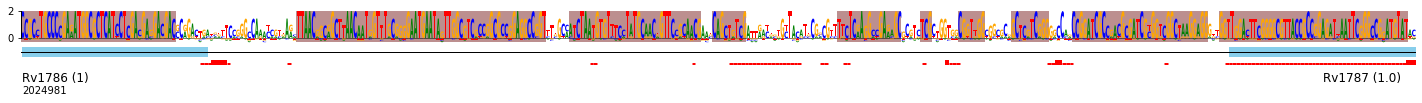

In [26]:
counts_df = lm.alignment_to_matrix(sequences = alignment.modified_sequence_list, to_type = 'counts', characters_to_ignore = '-', pseudocount=0)
background_probs = [0.25, 0.25, 0.25, 0.25]
for i, r in counts_df.iterrows():
    temp_relent = []
    num_gaps = alignment.num_sequences
    for k in range(4):
        num_gaps = num_gaps - r.iloc[k]
    for k in range(4):
        ct = r.iloc[k] + num_gaps*background_probs[k]
        if ct == 0:
            temp_relent.append(0)
        else:
            temp_relent.append((ct /alignment.num_sequences) * math.log((ct /alignment.num_sequences)/background_probs[k],2))
    for k in range(4):
        r.iloc[k] = temp_relent[k]

y = -1        
seqlogo = lm.Logo(counts_df, figsize = [25,1])
seqlogo.ax.plot([0, cds_end_pos], [y,y], color='skyblue', linewidth=10, solid_capstyle='butt')
for i in alignment_2.master_species_modified_sequence_insertions:
    #seqlogo.highlight_position_range(pmin=i, pmax=i, color='red')
    seqlogo.ax.plot([i[0], i[0]+1], [y-1,y-1], color='red', linewidth=5*i[1], solid_capstyle='butt')
seqlogo.ax.plot([non_cds_end_pos, alignment.modified_sequence_length], [y,y], color='skyblue', linewidth=10, solid_capstyle='butt')
seqlogo.ax.plot([utr_start_pos, utr_end_pos],[y, y], color='mediumslateblue', linewidth=10, solid_capstyle='butt')
for i, state in enumerate(hmm.viterbi_path):
    if state == 1:
        seqlogo.highlight_position_range(pmin=i, pmax=i, color='rosybrown')
    if state == 2:
        seqlogo.highlight_position_range(pmin=i, pmax=i, color='skyblue')
seqlogo.ax.text(0,3.2*y,locus_tag + ' ('+str(cds_strand)+')',fontsize=12)
seqlogo.ax.text(alignment.modified_sequence_length - offset/2,3.2*y,downstream_locus_tag+ ' ('+str(downstream_locus_strand)+')',fontsize=12)
seqlogo.ax.text(0, 3.5*y,int(non_cds_offset_start), verticalalignment='top', horizontalalignment='left')
    
seqlogo.style_spines(visible=False)
seqlogo.style_spines(spines=['left'], visible=True, bounds=[0, 2])
seqlogo.ax.set_xticks([])
seqlogo.ax.set_yticks([0,2])
seqlogo.ax.set_ylim([-2, 2])
seqlogo.ax.axhline(y, color = 'k', linewidth = 1)
seqlogo;

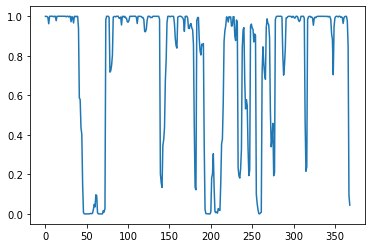

In [27]:
c = hmm.forward_probabilities[1] + hmm.backward_probabilities[1]
d = [math.exp(x - hmm.forward_ll) for x in c]
plt.plot(d)